# Chapter 9: Predicting Continuous Target Variables with Regression Analysis

## Exploring the Ames Housing dataset

### Loading the Ames Housing dataset into a data frame

The Ames Housing dataset consists of 2,930 examples and 80 features. For simplicity, we will only
work with a subset of the features, shown in the following list.

• Overall Qual: Rating for the overall material and finish of the house on a scale from 1 (very
poor) to 10 (excellent)

• Overall Cond: Rating for the overall condition of the house on a scale from 1 (very poor) to
10 (excellent)

• Gr Liv Area: Above grade (ground) living area in square feet

• Central Air: Central air conditioning (N=no, Y=yes)

• Total Bsmt SF: Total square feet of the basement area

• SalePrice: Sale price in U.S. dollars ($)

For the rest of this chapter, we will regard the sale price (SalePrice) as our target variable—the variable
that we want to predict using one or more of the five explanatory variables. Before we explore
this dataset further, let’s load it into a pandas DataFrame:

In [1]:
import pandas as pd

columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area', 'Central Air', 'Total Bsmt SF', 'SalePrice']

df = pd.read_csv('http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
                 sep = '\t',
                 usecols=columns)

df.head(5)

,Overall Qual,Overall Cond,Total Bsmt SF,Central Air,Gr Liv Area,SalePrice
0,6,5,1080.0,Y,1656,215000
1,5,6,882.0,Y,896,105000
2,6,6,1329.0,Y,1329,172000
3,7,5,2110.0,Y,2110,244000
4,5,5,928.0,Y,1629,189900


In [2]:
df.shape

(2930, 6)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Overall Qual   2930 non-null   int64  
 1   Overall Cond   2930 non-null   int64  
 2   Total Bsmt SF  2929 non-null   float64
 3   Central Air    2930 non-null   object 
 4   Gr Liv Area    2930 non-null   int64  
 5   SalePrice      2930 non-null   int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 137.5+ KB


In [4]:
df.describe()

,Overall Qual,Overall Cond,Total Bsmt SF,Gr Liv Area,SalePrice
count,2930.000000,2930.000000,2929.000000,2930.000000,2930.000000
mean,6.094881,5.563140,1051.614544,1499.690444,180796.060068
std,1.411026,1.111537,440.615067,505.508887,79886.692357
min,1.000000,1.000000,0.000000,334.000000,12789.000000
25%,5.000000,5.000000,793.000000,1126.000000,129500.000000
50%,6.000000,5.000000,990.000000,1442.000000,160000.000000
75%,7.000000,6.000000,1302.000000,1742.750000,213500.000000
max,10.000000,9.000000,6110.000000,5642.000000,755000.000000


In [5]:
df['Central Air'].value_counts()

,count
Central Air,
Y,2734
N,196


In [6]:
#mapping 'Central Air'
df['Central Air'] = df['Central Air'].map({'Y':1,'N':0})
df['Central Air'].value_counts()

,count
Central Air,
1,2734
0,196


In [7]:
df.isnull().sum()

,0
Overall Qual,0
Overall Cond,0
Total Bsmt SF,1
Central Air,0
Gr Liv Area,0
SalePrice,0


In [8]:
df.dropna(inplace=True)
df.isnull().sum()

,0
Overall Qual,0
Overall Cond,0
Total Bsmt SF,0
Central Air,0
Gr Liv Area,0
SalePrice,0


In [9]:
df.shape

(2929, 6)

### Visualizing the important characteristics of a dataset (EDA - Exploratory data anlysis)

First, we will create a scatterplot matrix that allows us to visualize the pair-wise correlations between
the different features in this dataset in one place.

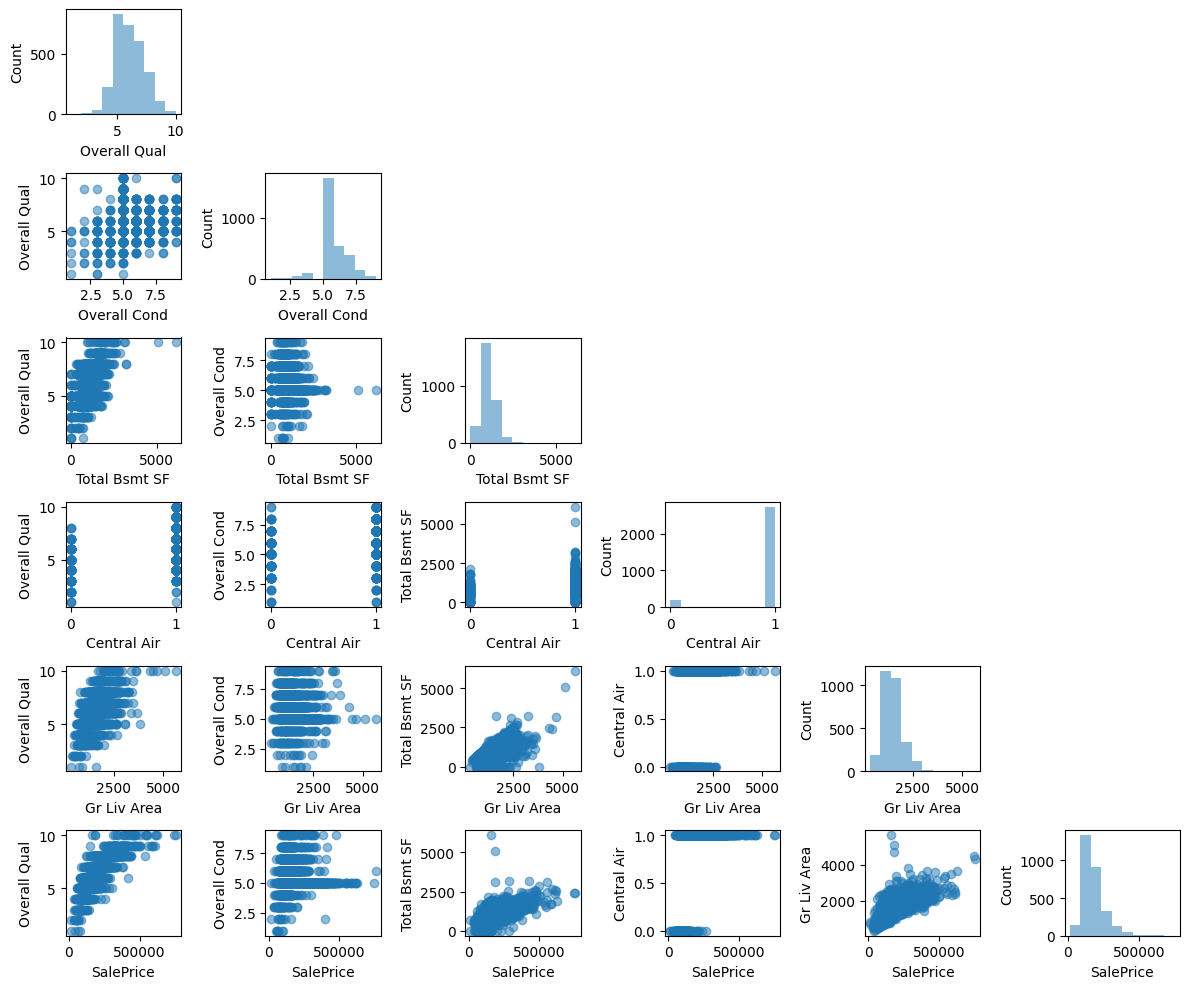

In [10]:
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix

scatterplotmatrix(df.values, figsize=(12,10), names=df.columns,alpha=0.5)
plt.tight_layout()
plt.show()

We can see (fifth column from the left of the bottom row) that there is a
somewhat linear relationship between the size of the living area above ground (Gr Liv Area) and
the sale price (SalePrice).

Furthermore, we can see in the histogram—the lower-right subplot in the scatterplot matrix—that the
SalePrice variable seems to be skewed by several outliers.

### Looking at relationships using a correlation matrix

The correlation matrix is a square matrix that contains the Pearson product-moment correlation
coefficient (often abbreviated as Pearson’s r), which measures the linear dependence between pairs
of features. The correlation coefficients are in the range –1 to 1. Two features have a perfect positive
correlation if r = 1, no correlation if r = 0, and a perfect negative correlation if r = –1. As mentioned
previously, Pearson’s correlation coefficient can simply be calculated as the covariance between two
features, x and y (numerator), divided by the product of their standard deviations (denominator)

In the following code example, we will use NumPy’s corrcoef function on the five feature columns
that we previously visualized in the scatterplot matrix, and we will use mlxtend’s heatmap function to
plot the correlation matrix array as a heat map:

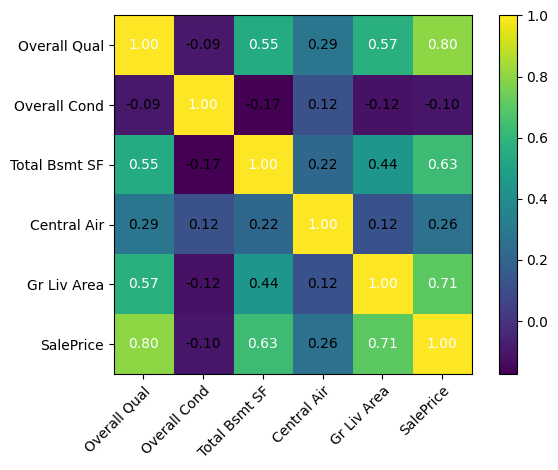

In [11]:
import numpy as np
from mlxtend.plotting import heatmap

cm = np.corrcoef(df.values.T)
hm = heatmap(cm, row_names=df.columns, column_names=df.columns)
plt.tight_layout()
plt.show()

To fit a linear regression model, we are interested in those features that have a high correlation with
our target variable, SalePrice. Looking at the previous correlation matrix, we can see that SalePrice
shows the largest correlation with the Gr Liv Area variable (0.71), which seems to be a good choice
for an exploratory variable to introduce the concepts of a simple linear regression model in the following
section.

## Implementing an ordinary least squares linear regression model

**Regresja OLS (Ordinary Least Squares)****

Metoda Najmniejszych Kwadratów
Ordinary Least Squares (OLS) to podstawowa metoda estymacji parametrów w regresji liniowej. Polega na minimalizacji sumy kwadratów różnic między wartościami rzeczywistymi a przewidywanymi. Jest szeroko stosowana w statystyce i uczeniu maszynowym.

### Solving regression for regression parameters with gradient descent

Essentially, OLS regression can be understood as Adaline without the threshold
function so that we obtain continuous target values instead of the class labels 0 and 1. To demonstrate
this, let’s take the GD implementation of Adaline from Chapter 2 and remove the threshold function
to implement our first linear regression model:

In [12]:
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_

    def predict(self, X):
        return self.net_input(X)

To see our LinearRegressionGD regressor in action, let’s use the Gr Living Area (size of the living
area above ground in square feet) feature from the Ames Housing dataset as the explanatory variable
and train a model that can predict SalePrice. Furthermore, we will standardize the variables for
better convergence of the GD algorithm. The code is as follows:

In [13]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

from sklearn.preprocessing import StandardScaler


sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()
lr = LinearRegressionGD(eta=0.1)
lr.fit(X_std, y_std)

Notice the workaround regarding y_std, using np.newaxis and flatten. Most data preprocessing
classes in scikit-learn expect data to be stored in two-dimensional arrays. In the previous code example,
the use of np.newaxis in y[:, np.newaxis] added a new dimension to the array. Then, after
StandardScaler returned the scaled variable, we converted it back to the original one-dimensional
array representation using the flatten() method for our convenience.

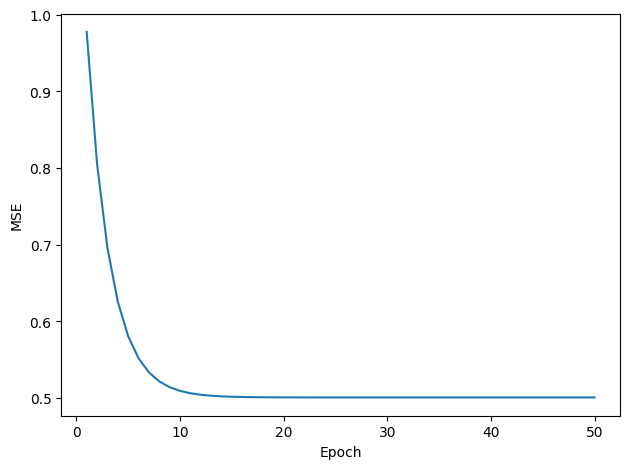

In [14]:
plt.plot(range(1, lr.n_iter+1), lr.losses_)
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.tight_layout()
plt.show()

Next, let’s visualize how well the linear regression line fits the training data. To do so, we will define a
simple helper function that will plot a scatterplot of the training examples and add the regression line:

In [15]:
def lin_regplot(X,y,model):
  plt.scatter(X,y,c='steelblue',edgecolor='white',s=70)
  plt.plot(X,model.predict(X),color='black',lw=2)

Now, we will use this lin_regplot function to plot the living area against the sale price:

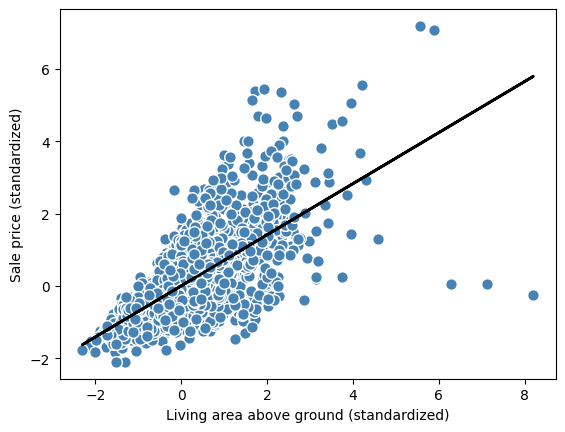

In [16]:
lin_regplot(X_std, y_std, lr)
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

plt.show()

As you can see the linear regression line reflects the general trend that house prices tend
to increase with the size of the living area. Although this observation makes sense, the data also tells us that the living area size does not explain
house prices very well in many cases.

In certain applications, it may also be important to report the predicted outcome variables on their
original scale. To scale the predicted price back onto the original price in U.S. dollars scale, we can
simply apply the inverse_transform method of StandardScaler:


In [17]:
feature_std = sc_x.transform(np.array([[2500]]))
target_std = lr.predict(feature_std)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))
print(f'Sale price: ${target_reverted.flatten()[0]:.2f}')

Sale price: $292507.07


In this code example, we used the previously trained linear regression model to predict the price of
a house with an aboveground living area of 2,500 square feet. According to our model, such a house
will be worth $292,507.07.

As a side note, it is also worth mentioning that we technically don’t have to update the intercept parameter
(for instance, the bias unit, b) if we are working with standardized variables, since the y axis
intercept is always 0 in those cases. We can quickly confirm this by printing the model parameters:

In [18]:
print(f'Slope: {lr.w_[0]:.3f}')
print(f'Intercept: {lr.b_[0]:.3f}')

Slope: 0.707
Intercept: -0.000


### Estimating the coefficient of a regression model via scikit-learn

The linear regression implementation in scikit-learn also works (better)
with unstandardized variables, since it does not use (S)GD-based optimization, so we can skip the
standardization step:

In [19]:
from sklearn.linear_model import LinearRegression

slr = LinearRegression()
slr.fit(X,y)
y_pred = slr.predict(X)
print(f'Slope: {slr.coef_[0]:.3f}')
print(f'Intercept: {slr.intercept_:.3f}')

Slope: 111.666
Intercept: 13342.979


As you can see from executing this code, scikit-learn’s LinearRegression model, fitted with the unstandardized
Gr Liv Area and SalePrice variables, yielded different model coefficients, since the
features have not been standardized. However, when we compare it to our GD implementation by
plotting SalePrice against Gr Liv Area, we can qualitatively see that it fits the data similarly well:

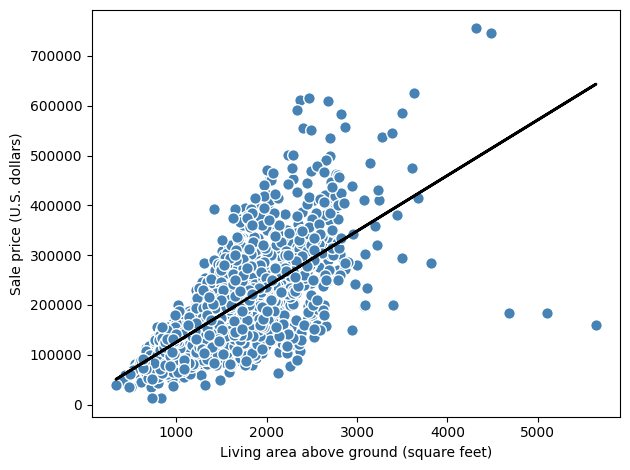

In [20]:
lin_regplot(X, y, slr)
plt.xlabel('Living area above ground (square feet)')
plt.ylabel('Sale price (U.S. dollars)')
plt.tight_layout()
plt.show()

## Fitting a robust regression model using RANSAC

As an alternative to throwing out outliers, we will look at a robust method of regression using the
RANdom SAmple Consensus (RANSAC) algorithm, which fits a regression model to a subset of the
data, the so-called inliers.

We can summarize the iterative RANSAC algorithm as follows:
1. Select a random number of examples to be inliers and fit the model.
2. Test all other data points against the fitted model and add those points that fall within a user-
given tolerance to the inliers.
3. Refit the model using all inliers.
4. Estimate the error of the fitted model versus the inliers.
5. Terminate the algorithm if the performance meets a certain user-defined threshold or if a
fixed number of iterations was reached; go back to step 1 otherwise.

In [21]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor(LinearRegression(),
                         max_trials=100,
                         min_samples=0.95,
                         residual_threshold=None,
                         random_state=123)
ransac.fit(X,y)

RANSACRegressor(estimator=LinearRegression(), min_samples=0.95,
                random_state=123)

We set the maximum number of iterations of the RANSACRegressor to 100, and using min_samples=0.95,
we set the minimum number of the randomly chosen training examples to be at least 95 percent of
the dataset.
By default (via residual_threshold=None), scikit-learn uses the MAD estimate to select the inlier
threshold, where MAD stands for the median absolute deviation of the target values, y. However, the
choice of an appropriate value for the inlier threshold is problem-specific, which is one disadvantage
of RANSAC.

Once we have fitted the RANSAC model, let’s obtain the inliers and outliers from the fitted RANSAC
linear regression model and plot them together with the linear fit:

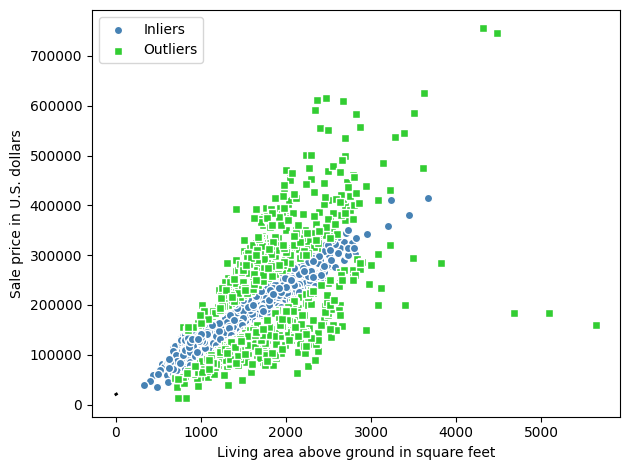

In [22]:
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

When we print the slope and intercept of the model by executing the following code, the linear regression
line will be slightly different from the fit that we obtained in the previous section without
using RANSAC:

In [23]:
print(f'Slope: {ransac.estimator_.coef_[0]:.3f}')
print(f'Intercept: {ransac.estimator_.intercept_:.3f}')

Slope: 106.348
Intercept: 20190.093


Remember that we set the residual_threshold parameter to None, so RANSAC was using the MAD to
compute the threshold for flagging inliers and outliers. The MAD, for this dataset, can be computed
as follows:

In [24]:
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))

median_absolute_deviation(y)

37000.0

Using RANSAC, we reduced the potential effect of the outliers in this dataset, but we don’t know whether
this approach will have a positive effect on the predictive performance for unseen data or not.

## Evaluating the performance of linear regression models

We will now
use all five features in the dataset and train a multiple regression model:

In [25]:
from sklearn.model_selection import train_test_split

target = 'SalePrice'
X = df.drop(target, axis=1).values
y = df[target].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123)

slr = LinearRegression()
slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

Since our model uses multiple explanatory variables, we can’t visualize the linear regression line (or
hyperplane, to be precise) in a two-dimensional plot, but we can plot the residuals (the differences or
vertical distances between the actual and predicted values) versus the predicted values to diagnose
our regression model. Residual plots are a commonly used graphical tool for diagnosing regression
models. They can help to detect nonlinearity and outliers and check whether the errors are randomly
distributed.


Using the following code, we will now plot a residual plot where we simply subtract the true target
variables from our predicted responses:

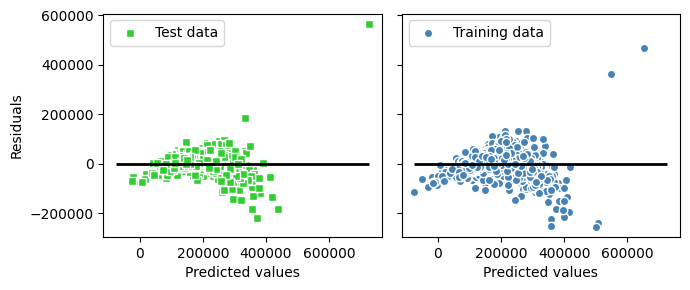

In [26]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()


plt.show()

Another useful quantitative measure of a model’s performance is the mean squared error (MSE) that
we discussed earlier as our loss function that we minimized to fit the linear regression model.

In [27]:
from sklearn.metrics import mean_squared_error

mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
print(f'MSE train: {mse_train:.3f}, MSE test: {mse_test:.3f}')

MSE train: 1497216245.853, MSE test: 1516565820.999


We can see that the MSE on the training dataset is larger than on the test set, which is an indicator
that our model is slightly overfitting the training data in this case. Note that it can be more intuitive to
show the error on the original unit scale (here, dollar instead of dollar-squared), which is why we may
choose to compute the square root of the MSE, called root mean squared error, or the mean absolute
error (MAE)

In [28]:
from sklearn.metrics import mean_absolute_error

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.3f}, MAE test: {mae_test:.3f}')

MAE train: 25983.027, MAE test: 24921.289


Based on the test set MAE, we can say that the model makes an error of approximately $25,000 on
average.

Calculating R^2 - coefficient of determination, which can be
understood as a standardized version of the MSE, for better interpretability of the model’s performance.



In [29]:
from sklearn.metrics import r2_score

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.3f}, R^2 test: {r2_test:.3f}')

R^2 train: 0.769, R^2 test: 0.752


Evaluated on the training data, the R2 of our model is 0.77, which isn’t great but also not too bad given
that we only work with a small set of features. However, the R2 on the test dataset is only slightly
smaller, at 0.75, which indicates that the model is only overfitting slightly:

## Using regularized methods for regression

## **Metody Regularyzacji w Regresji: Ridge, LASSO i Elastic Net**  

Regresja **Ridge**, **LASSO** oraz **Elastic Net** to techniki **regularyzacji w regresji liniowej**, które zapobiegają **overfittingowi** poprzez dodanie kar do współczynników modelu.  

---  

## **1️⃣ Ridge Regression (Regresja Grzbietowa, L2 Regularization)**  

### 🔹 **Opis**  
Regresja **Ridge** (znana także jako **L2-regularization**) dodaje do funkcji kosztu **karę w postaci sumy kwadratów współczynników regresji**.  

📌 **Jak działa Ridge?**  
- Dąży do **zmniejszenia wartości współczynników**, ale ich **nie zeruje**.  
- Szczególnie skuteczna przy **silnie skorelowanych zmiennych** (działa lepiej niż LASSO).  
- Nadaje się do problemów z dużą ilością cech (**high-dimensional data**).  

📌 **Wady:**  
- Nie wykonuje selekcji zmiennych (**nie zeruje współczynników**), więc **nie nadaje się do wyboru cech**.  

---

## **2️⃣ LASSO Regression (Least Absolute Shrinkage and Selection Operator, L1 Regularization)**  

### 🔹 **Opis**  
Regresja **LASSO** (znana jako **L1-regularization**) dodaje do funkcji kosztu **karę w postaci sumy wartości bezwzględnych współczynników regresji**.  

📌 **Jak działa LASSO?**  
- W przeciwieństwie do Ridge, **może zerować współczynniki regresji** → **wybiera najważniejsze cechy**.  
- Stosowane, gdy **istnieje wiele nieistotnych zmiennych i potrzebujemy selekcji cech**.  
- Dobre dla **rzadkich modeli** (**sparse models**), np. w analizie genów czy NLP.  

📌 **Wady:**  
- Może **prowadzić do niestabilnych wyników**, jeśli zmienne są silnie skorelowane (może arbitralnie wybierać jedną i zerować drugą).  
- Jeśli mamy **więcej zmiennych niż obserwacji**, LASSO wybierze maksymalnie **n** zmiennych (nie nadaje się do sytuacji, gdy liczba zmiennych > liczba próbek).  

---

## **3️⃣ Elastic Net (Połączenie Ridge i LASSO, L1 + L2 Regularization)**  

### 🔹 **Opis**  
Regresja **Elastic Net** łączy cechy **Ridge i LASSO**, dodając **karę w postaci kombinacji L1 i L2**.  

📌 **Jak działa Elastic Net?**  
- **Zeruje współczynniki jak LASSO**, ale **radzi sobie lepiej z korelacjami** jak Ridge.  
- Przydatne, gdy mamy **wiele cech i część jest skorelowana**.  
- Działa dobrze przy **dużym zbiorze cech, gdzie wiele z nich może być nieistotnych**.  

📌 **Wady:**  
- Trzeba dobrać **dwa parametry regularyzacji**: λ₁ i λ₂, co zwiększa **złożoność modelowania**.  
- Może być **trudniejsze w interpretacji** niż LASSO.  

## **🎯 Podsumowanie**
🔹 **Ridge** – używane, gdy mamy **wiele skorelowanych cech** i chcemy **uniknąć zerowania współczynników**.  
🔹 **LASSO** – wybiera tylko **najważniejsze cechy**, bo **zeruje współczynniki**.  
🔹 **Elastic Net** – najlepsze, gdy mamy **dużo skorelowanych cech i chcemy selekcję zmiennych**.  


Ridge:


In [30]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

LASSO:

In [31]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

ElasticNet:

In [32]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0)

## Turning a linear regression model into a curve - polynomial regression

### Adding polynomial terms using scikit-learn
We will now learn how to use the PolynomialFeatures transformer class from scikit-learn to add a
quadratic term (d = 2) to a simple regression problem with one explanatory variable. Then, we will
compare the polynomial to the linear fit by following these steps:

1. Add a second-degree polynomial term:

In [33]:
X = np.array([258.0, 270.0, 294.0,
              320.0, 342.0, 368.0,
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8,
              298.6, 314.2, 342.2,
              360.8, 368.0, 391.2,
              390.8])

In [34]:
from sklearn.preprocessing import PolynomialFeatures


lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

2. Fit a simple linear regression model for comparison:

In [35]:
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

3. Fit a multiple regression model on the transformed features for polynomial regression:

In [36]:
# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

4. Plot the results:

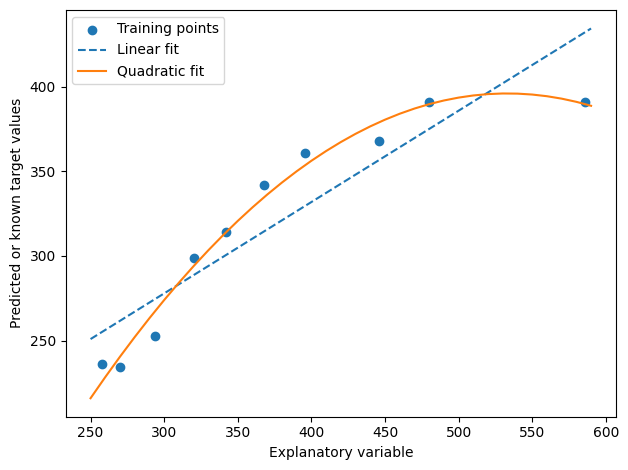

In [37]:
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In the resulting plot, you can see that the polynomial fit captures the relationship between the response
and explanatory variables much better than the linear fit

Next, we will compute the MSE and R^2 evaluation metrics:

In [38]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f'Training MSE linear: {mse_lin:.3f}'
      f', quadratic: {mse_quad:.3f}')


r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}'
      f', quadratic: {r2_quad:.3f}')

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


### Modeling nonlinear relationships in the Ames Housing dataset

By executing the following code, we will model the relationship
between sale prices and the living area above ground using second-degree (quadratic) and third-degree
(cubic) polynomials and compare that to a linear fit.


We start by removing the three outliers with a living area greater than 4,000 square feet, which we
can see in previous figures, so that these outliers don’t skew our regression fits:

In [39]:
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

X = X[df['Gr Liv Area'] < 4000]
y = y[df['Gr Liv Area'] < 4000]

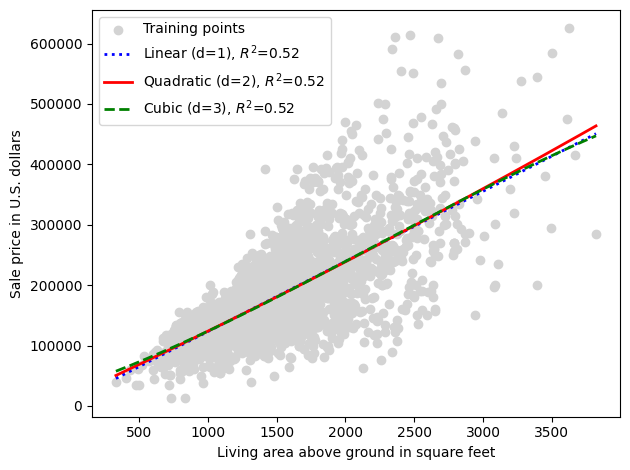

In [44]:
regr = LinearRegression()
 # creating quadratic and cubic features

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

#fit to features
X_fit = np.arange(X.min()-1,X.max() + 2,1)[:,np.newaxis]

regr = regr.fit(X, y)
y_linear_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr_quad = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr_cubic = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_linear_fit,
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue',
         lw=2,
         linestyle=':')

plt.plot(X_fit, y_quad_fit,
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red',
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit,
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green',
         lw=2,
         linestyle='--')


plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

As we can see, using quadratic or cubic features does not really have an effect. That’s because the
relationship between the two variables appears to be linear. So, let’s take a look at another feature,
namely, Overall Qual. The Overall Qual variable rates the overall quality of the material and finish
of the houses and is given on a scale from 1 to 10, where 10 is best:

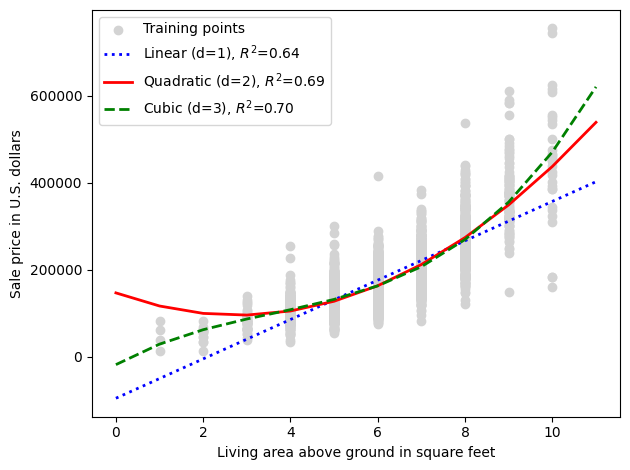

In [45]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values

egr = LinearRegression()
 # creating quadratic and cubic features

quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

#fit to features
X_fit = np.arange(X.min()-1,X.max() + 2,1)[:,np.newaxis]

regr = regr.fit(X, y)
y_linear_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr_quad = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr_cubic = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_linear_fit,
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue',
         lw=2,
         linestyle=':')

plt.plot(X_fit, y_quad_fit,
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red',
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit,
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green',
         lw=2,
         linestyle='--')


plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


## Dealing with nonlinear relationships using random forests

### Decision tree regression

To see what the line fit of a decision tree looks like, let’s use the DecisionTreeRegressor implemented
in scikit-learn to model the relationship between the SalePrice and Gr Living Area variables. Note
that SalePrice and Gr Living Area do not necessarily represent a nonlinear relationship, but this
feature combination still demonstrates the general aspects of a regression tree quite nicely:

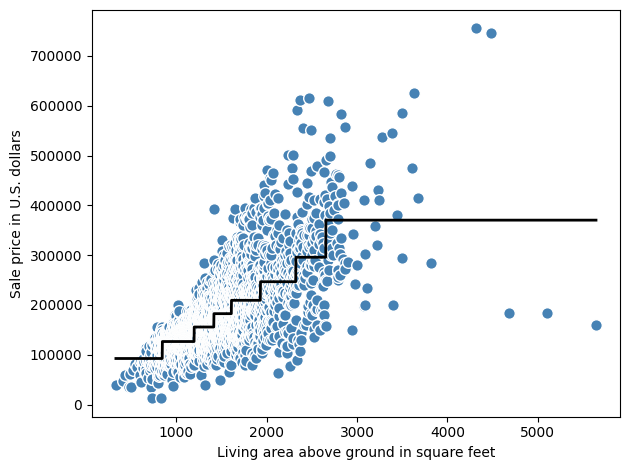

In [54]:
from sklearn.tree import DecisionTreeRegressor

X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.tight_layout()
plt.show()

In [55]:
tree_r2 = r2_score(y, tree.predict(X))
print(f'R^2 score: {tree_r2:.3f}')

R^2 score: 0.514


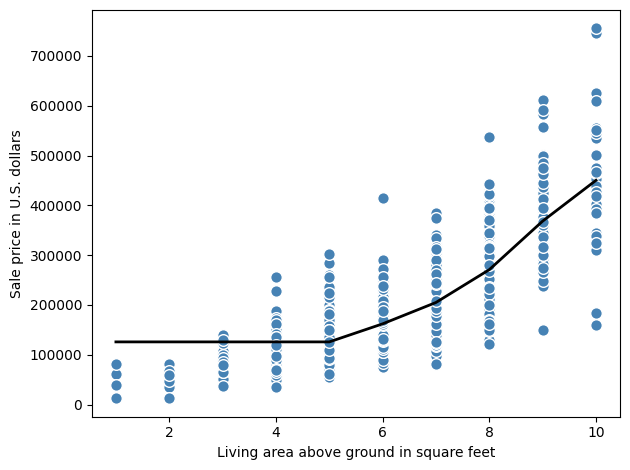

In [56]:
X = df[['Overall Qual']].values
y = df['SalePrice'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.tight_layout()
plt.show()

In [57]:
tree_r2 = r2_score(y, tree.predict(X))
print(f'R^2 score: {tree_r2:.3f}')

R^2 score: 0.685


### Random forest regression

Now, let’s use all the features in the Ames Housing dataset to fit a random forest regression model on
70 percent of the examples and evaluate its performance on the remaining 30 percent, as we have done
previously in the Evaluating the performance of linear regression models section. The code is as follows:

In [59]:
X = df.drop(columns='SalePrice').values
y = df['SalePrice'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='squared_error',
                               random_state=1,
                               n_jobs=-1)
forest.fit(X_train, y_train)

y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')


r2_train = r2_score(y_train, y_train_pred)
r2_test =r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}')

MAE train: 8305.18
MAE test: 20821.77
R^2 train: 0.98
R^2 test: 0.85


Unfortunately, you can see that the random forest tends to overfit the training data. However, it’s still
able to explain the relationship between the target and explanatory variables relatively well (𝑅^2 = 0.85
on the test dataset). For comparison, the linear model from the previous section, Evaluating the performance
of linear regression models, which was fit to the same dataset, was overfitting less but performed
worse on the test set (𝑅^2 = 0.75 ).

Lastly, let’s also take a look at the residuals of the prediction:

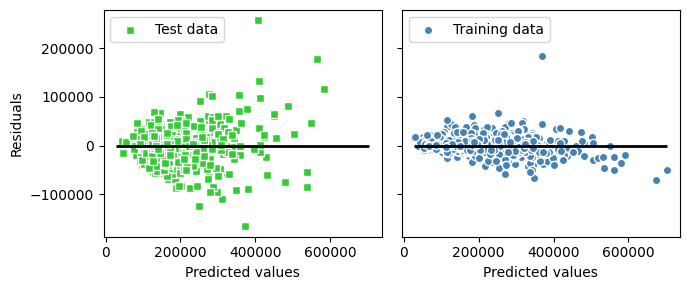

In [60]:
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

ax1.scatter(y_test_pred, y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()

plt.show()